In [1]:
import pandas as pd
import tensorflow as tf
import plotly.express as px
import plotly.figure_factory as ff
import sklearn as s
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

In [2]:
df_reviews=pd.read_csv('spotify_reviews.csv')
df_reviews

Time_submitted                                             Review  \
0      2022-07-09 15:00:00  Great music service, the audio is high quality...   
1      2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2      2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3      2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4      2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   
...                    ...                                                ...   
61589  2022-01-01 03:01:29  Even though it was communicated that lyrics fe...   
61590  2022-01-01 02:13:40  Use to be sooo good back when I had it, and wh...   
61591  2022-01-01 01:02:29  This app would be good if not for it taking ov...   
61592  2022-01-01 00:49:23  The app is good hard to navigate and won't jus...   
61593  2022-01-01 00:19:09  Its good but sometimes it doesnt load the musi...   

       Rating  Total_thumbsup Reply  
0           5               2   NaN  
1           5               1   NaN  
2           4               0   NaN  
3           1               1   NaN  
4           1               1   NaN  
...       ...             ...   ...  
61589       1               6   NaN  
61590       1               0   NaN  
61591       2              10   NaN  
61592       2               1   NaN  
61593       4               0   NaN  

[61594 rows x 5 columns]

In [3]:
# check data types
# time_submitted should be date time, but i will just drop it because i dont need it for this project 
print(df_reviews.dtypes)

Time_submitted    object
Review            object
Rating             int64
Total_thumbsup     int64
Reply             object
dtype: object


In [4]:
# drop unimportant columns
df=df_reviews[['Review','Rating']]
df

Review  Rating
0      Great music service, the audio is high quality...       5
1      Please ignore previous negative rating. This a...       5
2      This pop-up "Get the best Spotify experience o...       4
3        Really buggy and terrible to use as of recently       1
4      Dear Spotify why do I get songs that I didn't ...       1
...                                                  ...     ...
61589  Even though it was communicated that lyrics fe...       1
61590  Use to be sooo good back when I had it, and wh...       1
61591  This app would be good if not for it taking ov...       2
61592  The app is good hard to navigate and won't jus...       2
61593  Its good but sometimes it doesnt load the musi...       4

[61594 rows x 2 columns]

Split data into train, validation and unseen data set

# EDA & Preprocessing

In [5]:
# NAN Values check
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [6]:
# Duplicated columns check
df[df.duplicated(subset='Review')]

Review  Rating
1924                        Way too many ads       2
2495                      Good app for songs       5
2996                         I love Spotify.       5
3008                            Too many ads       1
3150                            Too much ads       1
...                                      ...     ...
49117              Great selection of music.       5
49915              Great selection of music.       5
58025          Great for music and podcasts.       4
58543  Great selection of music and podcasts       5
59155  Easy to use. Great selection of songs       5

[238 rows x 2 columns]

In [7]:
# Create a new column based on length of the reviews
df['length_of_text'] = [len(i.split(' ')) for i in df['Review']]
df.describe().round()

Rating  length_of_text
count  61594.0         61594.0
mean       3.0            31.0
std        2.0            23.0
min        1.0             2.0
25%        1.0            14.0
50%        3.0            25.0
75%        5.0            42.0
max        5.0           699.0

In [8]:
# check the longest one. the result are normal.
df["Review"][df.length_of_text==max(df.length_of_text)]

40566    I very rarely leave reviews and if I do, they'...
Name: Review, dtype: object

In [9]:
grouped_df=df.groupby('Rating')
grouped_df.describe().round()

length_of_text                                          
                count  mean   std  min   25%   50%   75%    max
Rating                                                         
1             17653.0  37.0  24.0  3.0  19.0  31.0  50.0  699.0
2              7118.0  40.0  24.0  3.0  21.0  35.0  53.0  165.0
3              6886.0  37.0  23.0  3.0  19.0  32.0  49.0  185.0
4              7842.0  31.0  22.0  3.0  14.0  25.0  41.0  222.0
5             22095.0  21.0  17.0  2.0   9.0  16.0  27.0  110.0

From above statistics we can see that people give positive rating (4-5) tend to make shorter length than neutral (3) and bad rating (1-2)<br>
we will dive further with some visualization  

In [10]:


# Distribution of the Length of the Reviews (Length of Text greater than 120 is neglected)
fig = px.histogram( df[df['length_of_text'] <= 120].length_of_text, 
                    marginal='box',
                    labels={"value": "Length of the Reviews"}
                    )
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.25)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.update_layout(title_text='Distribution of the Length of the Reviews',
                  title_x=0.5, title_font=dict(size=18), showlegend=False)
fig.show()



* most of the people give 2-20 sentence length
* there are several outlier, but the content are OK not some kind of bug or bot

In [11]:
x1=df[(df.Rating==1) & (df['length_of_text'] <= 120)].length_of_text
x2=df[(df.Rating==2) & (df['length_of_text'] <= 120)].length_of_text
x3=df[(df.Rating==3) & (df['length_of_text'] <= 120)].length_of_text
x4=df[(df.Rating==4) & (df['length_of_text'] <= 120)].length_of_text
x5=df[(df.Rating==5) & (df['length_of_text'] <= 120)].length_of_text

variables=[x1,x2,x3,x4,x5]
labels=[1,2,3,4,5]

# Create distplot with custom bin_size
fig = ff.create_distplot(variables,group_labels=labels,show_hist=False,show_rug=False)

fig.update_traces(marker=dict(line=dict(color='#000000', width=0.25)))
fig.update_layout(title_text='Distribution of the Length of the Reviews by their Ratings',
                  title_x=0.5, title_font=dict(size=18))
# fig.update_layout(barmode='overlay')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

same as the statistical analysis before, the distribution of people who give 4-5 Rating have shorter Reviews, while neutral and other have higher length.

In [12]:
fig = px.pie(df, names='Rating').update_traces(sort=False)
fig.show()

after quick look at above analysis, i'm decide to change to how we categorize our target.
even for normal people not an AI it's hard to differ between 2, 3, 4 base on review. some people can make really positive review but only give 3, others can criticize or bad mothing the app still give 5 star review.
with above statement in mind, I'm decice to split only to categorize positive and negative review and because 3 are have similar characteristic as 2 and 1, I will decide 3 became bad review

In [13]:
# bad: 0 good: 1
df.Rating= df.Rating.replace({5: 1, 4: 1, 3: 0, 2: 0, 1: 0})

In [14]:
# Top used 100 Words before Text Cleaning
FreqOfWords = df['Review'].str.split(expand=True).stack().value_counts()
FreqOfWords_top100 = FreqOfWords[:100]

fig = px.treemap(FreqOfWords_top100, path=[FreqOfWords_top100.index], values=0)
fig.update_layout(title_text='Top used 100 Words before Text Cleaning',
                  title_x=0.5, title_font=dict(size=18)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

From above words, we can see some stop word used (ex: to, the, I, etc.). we will remove theme later on.

change target into neutral,good and bad review

In [15]:
fig = px.pie(df, names='Rating')
fig.show()

In [16]:
'my','for','not','no','ads',"don't"

('my', 'for', 'not', 'no', 'ads', "don't")

In [17]:
def instant_pie(df,text) :
    for i in text:
        fig = px.pie(df[df['Review'].str.contains(i)], names='Rating')
        fig.update_traces(sort=True)
        fig.update_layout(title_text=i,
                        title_x=0.5, title_font=dict(size=18)
                        )
        fig.show()

In [18]:
text=['not','no','ads',"don't"]
instant_pie(df,text)

Cek if number gonna show us result

In [19]:
text=['9','8','7','6','5','4','3','2',"1",'0']
instant_pie(df,text)

In [20]:
random.choices(df.Review[df['Review'].str.contains('6')].to_list(),k=2)

["wrost app services. when 1st time after installation the app ads was come after 5 songs/1 ad. Then after-3 Songs/1 ad. Then 3 songs/2 ads then 2 songs/ 2 ads and after using 6 months after play only one song and the back to back 3 ads. premium charges are too high. Gaana is far better then this app. i'm uninstalling here right now and installing gaana app. please don't use this app.",
 "spotify is a good app but i don't like the new update. only skipping 6 songs an hour and i can't replay the sng i'm listening to. please fix that"]

In [21]:
random.choices(df.Review[df['Review'].str.contains('1')].to_list(),k=2)

["This app gets just one star from me as it stops randomly during songs, I pay a monthly prescription on premium. If this is not fixed soon I will be looking at other options of music. Over half the music I like isn't on this app or won't play. $14.95 a month for an app that doesn't function properly. Sort your app out or you'll find alot of users will leave.",
 "The feature I like the most is the timer! It enables me set a timer for 5 to 1 hour or to the end of the track and sleep. Other than that, I wish I could find more songs other than the known and English ones because it's sometimes hard to find some specific songs in other languages. (e.g Arabic)"]

In [22]:
random.choices(df.Review[df['Review'].str.contains('2')].to_list(),k=2)

["Shame that the developers won't update the app to allow for themed icon in Android 12. On top of the fact that the daily mixes don't make much sense based on artist selection.",
 "Ghost Spotify My spotify keeps playing by itself when it's closed And since 2 weeks ago I no longer have the play and stop option I need to reboot my phone everytime that it starts playing Very annoying Used to love the app until this happened"]

In [23]:
random.choices(df.Review[df['Review'].str.contains('3')].to_list(),k=2)

["I signed up for 30 day trial and can't play my play list",
 'Made watch a 30-second ad then proceeded to tell me to stop skipping when it played recommended songs before the songs on my playlist. would not play the songs I put on my playlist. This app sucks']

From text with number analysis above we can get some information:
* most people with number in their text are tend to leave bad score
* the reason '6' text got more bad review because the spotify has policy where whitin 1 hour you can only skip ads to 6 times
* while '0,1,2,3' text got more bad review because users explain problem with number, most of them dissapointed in about ads between 1-3 song, 30 minutes ad free are not working, and etc.

### emoticon check

In [24]:
random.choices(df.Review[df['Review'].str.contains(r'[\u263a-\U0001f645]')].to_list(),k=2)

['i have premium. a lot of the lyrics are wrong and some of my music cant be played offline even though ive downloaded it a hundred times. other than that, its cool. 🙂',
 "Such a nice app! I paid premium for students, and it's marvelous. And, these days I've been thinking about cancelling mi plan, so I did it and, damn! It was was so straightforward! I really appreciate the effortless way to let the people choose their own decision. Thanks, people who work there. I will come back soon 👍🏼"]

In [25]:
instant_pie(df,['😅','🙄','😡','❤️','🎶'])

from above analysis it seems emoticon will increase our model perfomance, so we will maintain and use emoticon in our training

## Split data Set

In [26]:
df=df[df.columns[:-1]]

In [27]:
# we will split data into training, validation and unseen data set
def split_train_test_val(df,train_test=.8,val=.6):
    train, validation, test = np.split(df.sample(frac=1), [int(val*len(df)),int(train_test*len(df))])

    # Assign the train split
    X_train = train[[train.columns[i] for i in range(train.shape[1]-1) ]].reset_index(drop=True)
    y_train = train[train.columns[-1]].reset_index(drop=True)
    # Assign the test split
    X_test = test[[test.columns[i] for i in range(train.shape[1]-1) ]].reset_index(drop=True)
    y_test = test[test.columns[-1]].reset_index(drop=True)
    # Assign the validation split
    X_val = validation[[validation.columns[i] for i in 
                        range(validation.shape[1]-1) ]].reset_index(drop=True)
    y_val = validation[validation.columns[-1]].reset_index(drop=True)

    # Print the sets data shapes
    print("X_train shape: {}".format(X_train.shape))
    print("X_test shape: {}".format(X_test.shape))
    print("y_train shape: {}".format(y_train.shape))
    print("y_test shape: {}".format(y_test.shape))
    print("X_val shape: {}".format(X_val.shape))
    print("y_val shape: {}".format(y_val.shape))
    return X_train,y_train,X_test,y_test,X_val,y_val

X_train,y_train,X_test,y_test,X_val,y_val=split_train_test_val(df)

X_train shape: (36956, 1)
X_test shape: (12319, 1)
y_train shape: (36956,)
y_test shape: (12319,)
X_val shape: (12319, 1)
y_val shape: (12319,)


## Text Preprocessing

in this project we will preprocess our data with some technique:
* Cleaning 
* Tokenization
* Stop word removal
* Stemming/lemmatization

In [28]:
import re
import string
import emoji
import regex
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('omw-1.4')

def removePunctuation(strs):
    remove = string.punctuation
    remove = remove.replace("-", "") # don't remove hyphens
    remove = remove.replace("@", "") # don't remove hyphens
    remove = remove.replace("#", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern

    h = re.sub(pattern, " ", strs) 
    return h

def emoji_handling(text,remove_emoji=False):
    emoji_list = []
    word_list=[]
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
        else:
            word_list.append(word)
    word_str="".join(word_list)
    emoji_str=" ".join(emoji_list)
    combined=word_str+" "+emoji_str
    if emoji==True:
        return word_str
    return combined

def replace(strs):
    strs = strs.replace('\n','')
    strs = strs.replace('\t','')
    strs = strs.replace('rt','')
    return strs

def tokenize(strs): 
    tokenizer = TweetTokenizer()
    nltk_tokens = tokenizer.tokenize(strs)
    return nltk_tokens

def removeAkunHastags(tokens):
    # Clean @
    regexp = re.compile(r'@[a-z]') 
    filtered = filter(lambda i: not regexp.search(i), tokens)
    filtered = [i for i in tokens if not regexp.search(i)]
    # Clean hashtag(#)
    regexp = re.compile(r'#[a-z0-9]') 
    filtered = filter(lambda i: not regexp.search(i), filtered)
    filtered = [i for i in filtered if not regexp.search(i)]
    return filtered

def clean_stopwords(text,exception=[]):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    for word in exception:
        stopwords.discard(word)
    return [item for item in text if item not in stopwords]

def lemmatization(inputs):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word=x, pos='v') for x in inputs]

def stemming(inputs):
    ps = nltk.PorterStemmer()
    return [ps.stem(word=x, pos='v') for x in inputs]

def main_preprocess(df,columns,stemming=False,remove_emoji=False,exception=[]):
    data = df.copy()
    
    #Cleaning
    data['text'] = [i.lower() for i in df[columns].astype(str)] #lowertext
    data['text'] = [re.sub(r'http.*', '', i) for i in data.text] #remove link
    data['text'] = [re.sub(r'<.*?>', '', i) for i in data.text] #remove html
    data['text'] = [removePunctuation(i) for i in data.text] #remove punctuation
    data['text'] = [replace(j) for j in data.text] #replace \n \t rt
    data['text'] = data['text'].apply(lambda x: emoji_handling(x,remove_emoji))
    data['token'] = [nltk.word_tokenize(i) for i in data.text] #tokenize string
    data['token'] = [removeAkunHastags(i) for i in data.token] #remove akun, hastags, emoji
    data['clean_token'] = data['token'].apply(lambda x: clean_stopwords(x,exception)) #remove stop words

    #Stemming/Lemmatization
    if stemming== True:
        ps = nltk.PorterStemmer()
        data['clean_token'] = data['clean_token'].apply(stemming)
    else:
        data['clean_token'] = data['clean_token'].apply(lemmatization)
    print('job is done')
    return data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# complete erase some text
X_trained= main_preprocess(X_train,'Review',remove_emoji=True)
X_tested= main_preprocess(X_test,'Review',remove_emoji=True)
X_valed= main_preprocess(X_val,'Review',remove_emoji=True)

# emoticon and some text retained
exception=['not','no','ads',"don't"]
X_trained_retain= main_preprocess(X_train,'Review',exception=exception)
X_tested_retain= main_preprocess(X_test,'Review',exception=exception)
X_valed_retain= main_preprocess(X_val,'Review',exception=exception)

job is done
job is done
job is done
job is done
job is done
job is done


In [30]:
# complete erase some text
X_trained['ReviewFinal'] = X_trained['clean_token'].str.join(' ')
X_tested['ReviewFinal'] = X_tested['clean_token'].str.join(' ')
X_valed['ReviewFinal'] = X_valed['clean_token'].str.join(' ')

# emoticon and some text retained
X_trained_retain['ReviewFinal'] = X_trained_retain['clean_token'].str.join(' ')
X_tested_retain['ReviewFinal'] = X_tested_retain['clean_token'].str.join(' ')
X_valed_retain['ReviewFinal'] = X_tested_retain['clean_token'].str.join(' ')

In [31]:
X_trained.clean_token[16939]

['30', 'mins', '1-2', 'ads', 'pc', '10', 'mins', '3', 'ads', 'android', 'ios']

In [32]:
X_trained_retain.clean_token[16939]

['30', 'mins', '1-2', 'ads', 'pc', '10', 'mins', '3', 'ads', 'android', 'ios']

In [33]:
# complete erase some text
X_train= X_trained['ReviewFinal']
X_test= X_tested['ReviewFinal']
X_val= X_valed['ReviewFinal']

# emoticon and some text retained
X_train_retain= X_trained_retain['ReviewFinal']
X_test_retain= X_tested_retain['ReviewFinal']
X_val_retain= X_valed_retain['ReviewFinal']

In [34]:
df_split=X_trained['clean_token']
df_split=pd.DataFrame(df_split.tolist())
# Top used 100 Words before Text Cleaning
FreqOfWords = df_split.stack().value_counts()
FreqOfWords_top100 = FreqOfWords[:100]

fig = px.treemap(FreqOfWords_top100, path=[FreqOfWords_top100.index], values=0)
fig.update_layout(title_text='Top used 100 Words after Cleaning',
                  title_x=0.5, title_font=dict(size=18)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [35]:
df_split=X_trained_retain['clean_token']
df_split=pd.DataFrame(df_split.tolist())
# Top used 100 Words before Text Cleaning
FreqOfWords = df_split.stack().value_counts()
FreqOfWords_top100 = FreqOfWords[:100]

fig = px.treemap(FreqOfWords_top100, path=[FreqOfWords_top100.index], values=0)
fig.update_layout(title_text='Top used 100 Words after Cleaning',
                  title_x=0.5, title_font=dict(size=18)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

# Modeling 1

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenizing with Tensorflow
num_words = 20000  # Maximum number of tokens for the Tokenizer

# Define Tokenizer and fit it with the X_train
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Apply the Tokenizer
Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_test = tokenizer.texts_to_sequences(X_test)

print('Non-tokenized Version: ', X_train[100])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[200]]))
print('--' * 20)
print('Non-tokenized Version: ', X_train[200])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[200]]))

Non-tokenized Version:  best music app years
Tokenized Version:  [[16, 3, 102, 12, 5]]
----------------------------------------
Non-tokenized Version:  great music quality love spotify
Tokenized Version:  [[16, 3, 102, 12, 5]]


In [62]:
X_train=X_trained['ReviewFinal'].values
X_test=X_tested['ReviewFinal'].values
X_val=X_valed['ReviewFinal'].values

In [63]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [64]:
# Applying Padding
maxLen = 110  # Maximum length of each text
Padded_train = pad_sequences(Tokenized_train, maxlen=maxLen, padding='post')
Padded_test = pad_sequences(Tokenized_test, maxlen=maxLen, padding='post')

In [65]:
import tensorflow as tf
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Bidirectional
from keras import Sequential
from keras.layers import LSTM
from keras import regularizers

model = Sequential()

model.add(Embedding(num_words, 64, input_length=maxLen))
model.add(Dropout(0.75))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 110, 64)           1280000   
                                                                 
 dropout_4 (Dropout)         (None, 110, 64)           0         
                                                                 
 batch_normalization_2 (Batc  (None, 110, 64)          256       
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 16)               4672      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [66]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
# Define Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  mode='auto', patience=5,
                                                  restore_best_weights=True)

In [68]:
# Fit the model
epochs = 100
hist = model.fit(Padded_train, y_train, batch_size=64, epochs=epochs,
                 validation_data=(Padded_test, y_test),
                 callbacks=[early_stopping])

Epoch 1/100
578/578 [==============================] - 45s 73ms/step - loss: 0.5164 - accuracy: 0.7523 - val_loss: 0.3806 - val_accuracy: 0.8549
Epoch 2/100
578/578 [==============================] - 42s 72ms/step - loss: 0.4035 - accuracy: 0.8360 - val_loss: 0.3431 - val_accuracy: 0.8583
Epoch 3/100
578/578 [==============================] - 42s 72ms/step - loss: 0.3822 - accuracy: 0.8494 - val_loss: 0.3412 - val_accuracy: 0.8608
Epoch 4/100
578/578 [==============================] - 42s 72ms/step - loss: 0.3599 - accuracy: 0.8584 - val_loss: 0.3574 - val_accuracy: 0.8600
Epoch 5/100
578/578 [==============================] - 42s 72ms/step - loss: 0.3460 - accuracy: 0.8628 - val_loss: 0.3461 - val_accuracy: 0.8608
Epoch 6/100
578/578 [==============================] - 42s 72ms/step - loss: 0.3367 - accuracy: 0.8687 - val_loss: 0.3518 - val_accuracy: 0.8594
Epoch 7/100
578/578 [==============================] - 41s 71ms/step - loss: 0.3325 - accuracy: 0.8705 - val_loss: 0.3534 - val_ac

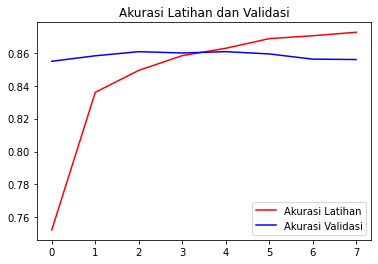

<Figure size 432x288 with 0 Axes>

In [69]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Latihan')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Akurasi Latihan dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [70]:
# Preparing the Test Data
Tokenized_val = tokenizer.texts_to_sequences(X_val)
Padded_val = pad_sequences(Tokenized_val, maxlen=maxLen, padding='post')

# Evaluating the Test Data
model.evaluate(Padded_val, y_val)

385/385 [==============================] - 3s 8ms/step - loss: 0.3258 - accuracy: 0.8640


[0.3257772624492645, 0.8639500141143799]

In [71]:
# Classification Report for Test Data
print(classification_report(y_test, model.predict(Padded_test).argmax(axis=1)))

385/385 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      6333
           1       0.90      0.80      0.85      5986

    accuracy                           0.86     12319
   macro avg       0.87      0.86      0.86     12319
weighted avg       0.86      0.86      0.86     12319



In [72]:
# Classification Report for Validation Data
print(classification_report(y_val, model.predict(Padded_val).argmax(axis=1)))

385/385 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      6334
           1       0.91      0.80      0.85      5985

    accuracy                           0.86     12319
   macro avg       0.87      0.86      0.86     12319
weighted avg       0.87      0.86      0.86     12319



### with emoticon and some text

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenizing with Tensorflow
num_words = 20000  # Maximum number of tokens for the Tokenizer

# Define Tokenizer and fit it with the X_train
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_retain)

# Apply the Tokenizer
Tokenized_train = tokenizer.texts_to_sequences(X_train_retain)
Tokenized_test = tokenizer.texts_to_sequences(X_test_retain)

print('Non-tokenized Version: ', X_train_retain[100])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train_retain[200]]))
print('--' * 20)
print('Non-tokenized Version: ', X_train_retain[200])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train_retain[200]]))

Non-tokenized Version:  best music app years
Tokenized Version:  [[17, 3, 104, 13, 5]]
----------------------------------------
Non-tokenized Version:  great music quality love spotify
Tokenized Version:  [[17, 3, 104, 13, 5]]


In [74]:
print('Non-tokenized Version: ', X_train_retain[53])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train_retain[53]]))
print('--' * 20)
print('Non-tokenized Version: ', X_train_retain[78])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train_retain[78]]))

Non-tokenized Version:  latest update not playlist recently add stupid
Tokenized Version:  [[196, 21, 9, 18, 167, 28, 352]]
----------------------------------------
Non-tokenized Version:  good many ads 😔
Tokenized Version:  [[15, 47, 16, 903]]


In [75]:
X_train_retain=X_trained_retain['ReviewFinal'].values
X_test_retain=X_tested_retain['ReviewFinal'].values
X_val_retain=X_valed_retain['ReviewFinal'].values

In [76]:
# Applying Padding
maxLen = 110  # Maximum length of each text
Padded_train = pad_sequences(Tokenized_train, maxlen=maxLen, padding='post')
Padded_test = pad_sequences(Tokenized_test, maxlen=maxLen, padding='post')

In [77]:
import tensorflow as tf
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Bidirectional
from keras import Sequential
from keras.layers import LSTM
from keras import regularizers

model = Sequential()

model.add(Embedding(num_words, 64, input_length=maxLen))
model.add(Dropout(0.75))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 110, 64)           1280000   
                                                                 
 dropout_6 (Dropout)         (None, 110, 64)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 110, 64)          256       
 hNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               4672      
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [78]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
# Define Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  mode='auto', patience=5,
                                                  restore_best_weights=True)

In [80]:
# Fit the model
epochs = 50
hist = model.fit(Padded_train, y_train, batch_size=64, epochs=epochs,
                 validation_data=(Padded_test, y_test),
                 callbacks=[early_stopping])

Epoch 1/50
578/578 [==============================] - 46s 74ms/step - loss: 0.5714 - accuracy: 0.7107 - val_loss: 0.4336 - val_accuracy: 0.8239
Epoch 2/50
578/578 [==============================] - 42s 73ms/step - loss: 0.4337 - accuracy: 0.8230 - val_loss: 0.3440 - val_accuracy: 0.8543
Epoch 3/50
578/578 [==============================] - 42s 73ms/step - loss: 0.4001 - accuracy: 0.8399 - val_loss: 0.3364 - val_accuracy: 0.8600
Epoch 4/50
578/578 [==============================] - 42s 73ms/step - loss: 0.3791 - accuracy: 0.8493 - val_loss: 0.3373 - val_accuracy: 0.8618
Epoch 5/50
578/578 [==============================] - 42s 73ms/step - loss: 0.3632 - accuracy: 0.8580 - val_loss: 0.3532 - val_accuracy: 0.8619
Epoch 6/50
578/578 [==============================] - 42s 73ms/step - loss: 0.3513 - accuracy: 0.8642 - val_loss: 0.3468 - val_accuracy: 0.8594
Epoch 7/50
578/578 [==============================] - 42s 73ms/step - loss: 0.3400 - accuracy: 0.8713 - val_loss: 0.3431 - val_accuracy:

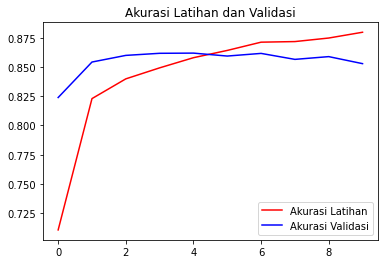

<Figure size 432x288 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Latihan')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Akurasi Latihan dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [82]:
# Preparing the Test Data
Tokenized_val = tokenizer.texts_to_sequences(X_val)
Padded_val = pad_sequences(Tokenized_val, maxlen=maxLen, padding='post')

# Evaluating the Test Data
model.evaluate(Padded_val, y_val)

385/385 [==============================] - 3s 8ms/step - loss: 0.3361 - accuracy: 0.8650


[0.33608636260032654, 0.8650052547454834]

In [83]:
# Classification Report for Test Data
print(classification_report(y_test, model.predict(Padded_test).argmax(axis=1)))

385/385 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      6333
           1       0.89      0.82      0.85      5986

    accuracy                           0.86     12319
   macro avg       0.86      0.86      0.86     12319
weighted avg       0.86      0.86      0.86     12319



In [84]:
# Classification Report for validation test Data
print(classification_report(y_val, model.predict(Padded_val).argmax(axis=1)))

385/385 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      6334
           1       0.88      0.84      0.86      5985

    accuracy                           0.87     12319
   macro avg       0.87      0.86      0.86     12319
weighted avg       0.87      0.87      0.86     12319



# Conclussion

* the final best accuracy we can get with training test is  0.8798 with test accuracy 0.86 and validation/unseen data 0.87
* there is not any significant difference between remove or retain emoticon.